In [1]:
import os
import cv2
import glob
import time
import copy
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## 資料處理，從標記檔中取得行人影像並依照 reid 分類

In [2]:
def getImagesInDir(dir_path):
    img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
    image_list = []
    for img_format in img_formats:
        for filename in glob.glob(dir_path + f'/*.{img_format}'):
            image_list.append(filename)
    return image_list

In [3]:
classes = ['pedestrian']
img_dir = 'person_reid_datasets/train/JPEGImages/'
ann_dir = 'person_reid_datasets/train/Annotations/'
image_paths = getImagesInDir(img_dir)
out_dir = 'reid/data'

In [4]:
# 創建資料夾
if os.path.exists(out_dir.split('/')[0]):
    shutil.rmtree(out_dir.split('/')[0])  # delete output folder
os.makedirs(out_dir)  # make new output folder

In [5]:
for img_path in tqdm(image_paths, total=len(image_paths)):
    # read image
    img = cv2.imread(img_path)
    
    basename = os.path.basename(img_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(ann_dir + '/' + basename_no_ext + '.xml')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    cnt=0
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        reid = obj.find('reid').text[:-2]
        crop_img = img[int(b[2]):int(b[3]), int(b[0]):int(b[1]), :]
        out_reid_dir = os.path.join(out_dir, reid)
        if not os.path.exists(out_reid_dir):
            os.mkdir(out_reid_dir)
        cv2.imwrite(os.path.join(out_reid_dir, basename_no_ext+'_'+str(cnt))+'.jpg', crop_img)
        cnt+=1

100%|██████████| 723/723 [00:08<00:00, 86.90it/s] 


In [5]:
out_dir = 'reid/data'
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(out_dir):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(each)
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data.head()

,file,class
0,c6s2_058318_4.jpg,624
1,c5s2_049580_3.jpg,624
2,c5s2_070777_4.jpg,624
3,c4s4_050685_1.jpg,624
4,c6s2_058393_1.jpg,624


In [6]:
data.groupby('class').count().sort_values(['file'])

,file
class,
285,1
545,1
714,1
344,2
618,2
...,...
192,45
55,46
173,48


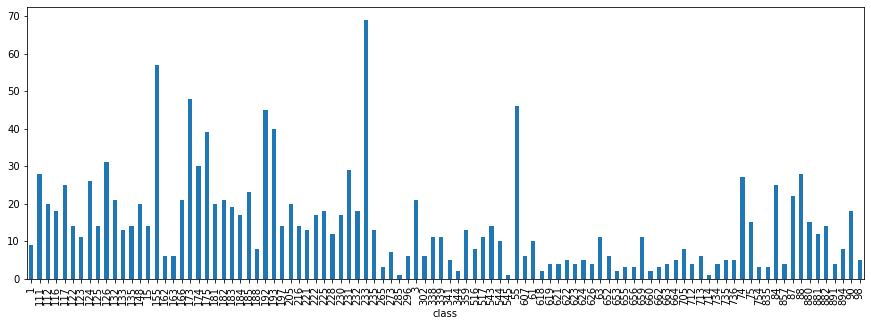

In [7]:
data.groupby('class').count().plot(kind='bar', figsize=(15, 5), legend=False)

In [8]:
class_num = len(data.groupby('class').count())

## 切分訓練集和驗證集

In [10]:
def make_dir(source, target):
    dir_names = os.listdir(source)
    for names in dir_names:
        for i in ['train', 'valid']:
            path = target + '/' + i + '/' + names
            if not os.path.exists(path):
                os.makedirs(path)
                
def divideTrainValid(source, target):
    pic_name = os.listdir(source)
    
    for classes in pic_name:
        pic_classes_name = os.listdir(os.path.join(source, classes))
        if '.ipynb_checkpoints' in pic_classes_name:
            pic_classes_name.remove('.ipynb_checkpoints')
        random.shuffle(pic_classes_name)
        
        if len(pic_classes_name) == 1:
            train_list = pic_classes_name[:]
            valid_list = pic_classes_name[:]
        else:
            train_list = pic_classes_name[0:int(0.9*len(pic_classes_name))]
            valid_list = pic_classes_name[int(0.9*len(pic_classes_name)):]
        
        for train_pic in train_list:
            shutil.copyfile(source + '/' + classes + '/' + train_pic, target + '/train/' + classes + '/' + train_pic)
        for valid_pic in valid_list:
            shutil.copyfile(source + '/' + classes + '/' + valid_pic, target + '/valid/' + classes + '/' + valid_pic)
            
filepath = 'reid/data'
dist = 'reid'
make_dir(filepath, dist)
divideTrainValid(filepath, dist)

## 讀入 Pre-trained Model

In [11]:
!pip install pytorch_metric_learning -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import torchvision
from torchvision import datasets, models, transforms
from pytorch_metric_learning import losses, miners 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, linear=512, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear>0:
            add_block += [nn.Linear(input_dim, linear)]
        else:
            linear = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(linear)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(linear, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return [x,f]
        else:
            x = self.classifier(x)
            return x
        
class ft_net(nn.Module):
    def __init__(self, class_num=100, droprate=0.5, circle=False, linear_num=512):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        self.model = nn.Sequential(*list(model_ft.children())[:-1])
        self.classifier = ClassBlock(2048, class_num, droprate, linear=linear_num, return_f = circle)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x

In [9]:
model_ft = ft_net(class_num, 0.5, circle = True, linear_num=512)
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [10]:
model_ft

ft_net(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

## Data Augmentation

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((384, 192)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.1, 0.15), ratio=(1, 1), value=(0, 0, 0))
    ]),
    'valid': transforms.Compose([
        transforms.Resize((384, 192)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'reid'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [16]:
dataset_sizes

{'train': 1247, 'valid': 194}

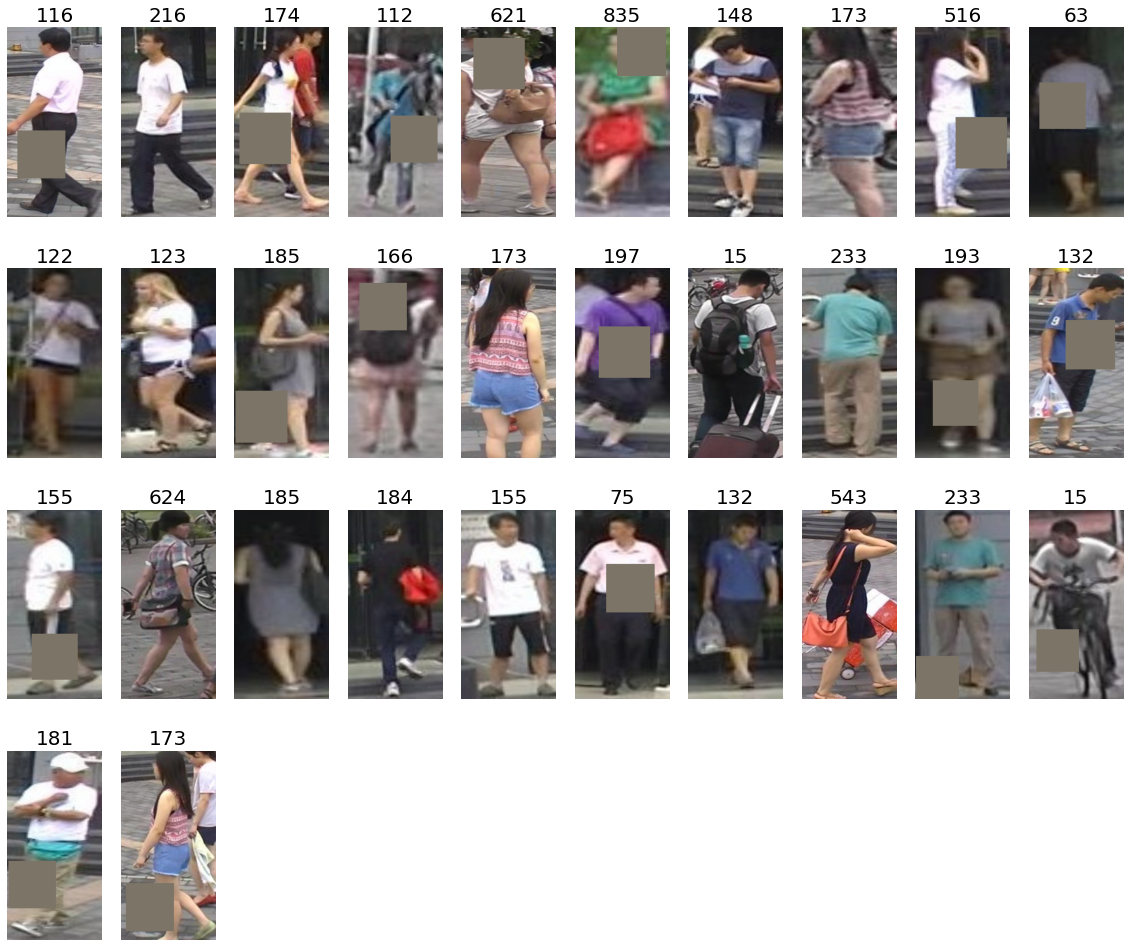

In [17]:
def postprocess(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    out = np.clip(inp, 0, 1)
    return out

def imshow(inputs, labels, preds=None):
    grid_x, grid_y = len(inputs)//10+1, 10
    plt.figure(figsize=(20, 17))
    """Imshow for Tensor."""
    if preds is None:
        i = 1
        for inp, cls in zip(inputs, labels):
            out = postprocess(inp)
            plt.subplot(grid_x, grid_y, i)
            plt.title(class_names[int(cls)], fontsize=20)
            plt.imshow(out)
            plt.axis('off')
            i+=1
    else:
        i = 1
        for inp, cls, pred in zip(inputs, labels, preds):
            out = postprocess(inp)
            plt.subplot(grid_x, grid_y, i)
            if cls != pred:
                plt.title('pred:'+str(class_names[int(pred)])+'\nlable:'+str(class_names[int(cls)]), color = 'r', fontsize=18)
            else:
                plt.title('pred:'+str(class_names[int(pred)])+'\nlable:'+str(class_names[int(cls)]), fontsize=18)
            plt.imshow(out)
            plt.axis('off')
            i+=1        

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
imshow(inputs, classes)

## 開始訓練模型

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    criterion_cosface = losses.CosFaceLoss(num_classes=100, embedding_size=512)

    train_history = {'train_loss':[], 'valid_loss':[], 'train_acc':[], 'valid_acc':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                now_batch_size, c, h, w = inputs.shape
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                if phase == 'valid':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                
                sm = nn.Softmax(dim=1)
                log_sm = nn.LogSoftmax(dim=1)
                logits, ff = outputs
                fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
                ff = ff.div(fnorm.expand_as(ff))
                loss = criterion(logits, labels)
                _, preds = torch.max(logits.data, 1)
                loss += criterion_cosface(ff, labels)/now_batch_size
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * now_batch_size
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            train_history[phase+'_loss'].append(epoch_loss)
            train_history[phase+'_acc'].append(float(epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_history, model

In [19]:
train_history, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                      num_epochs=20)
torch.save(model_ft, 'reid_model_cosine.pth')

Epoch 0/19
----------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 4.1404 Acc: 0.3168
valid Loss: 3.3590 Acc: 0.4691
Epoch 1/19
----------
train Loss: 2.0785 Acc: 0.6913
valid Loss: 2.0835 Acc: 0.7216
Epoch 2/19
----------
train Loss: 1.3230 Acc: 0.8508
valid Loss: 1.5738 Acc: 0.7990
Epoch 3/19
----------
train Loss: 0.9076 Acc: 0.9302
valid Loss: 1.2231 Acc: 0.8299
Epoch 4/19
----------
train Loss: 0.6763 Acc: 0.9703
valid Loss: 1.0319 Acc: 0.8969
Epoch 5/19
----------
train Loss: 0.5589 Acc: 0.9848
valid Loss: 0.8659 Acc: 0.9124
Epoch 6/19
----------
train Loss: 0.5245 Acc: 0.9920
valid Loss: 0.8716 Acc: 0.9175
Epoch 7/19
----------
train Loss: 0.5062 Acc: 0.9912
valid Loss: 0.8605 Acc: 0.9227
Epoch 8/19
----------
train Loss: 0.4914 Acc: 0.9912
valid Loss: 0.7816 Acc: 0.9175
Epoch 9/19
----------
train Loss: 0.4707 Acc: 0.9928
valid Loss: 0.8294 Acc: 0.9227
Epoch 10/19
----------
train Loss: 0.4685 Acc: 0.9928
valid Loss: 0.8887 Acc: 0.9175
Epoch 11/19
----------
train Loss: 0.4640 Acc: 0.9928
valid Loss: 0.8445 Acc: 0.9175
Epoch 12/19


## 訓練結果視覺化

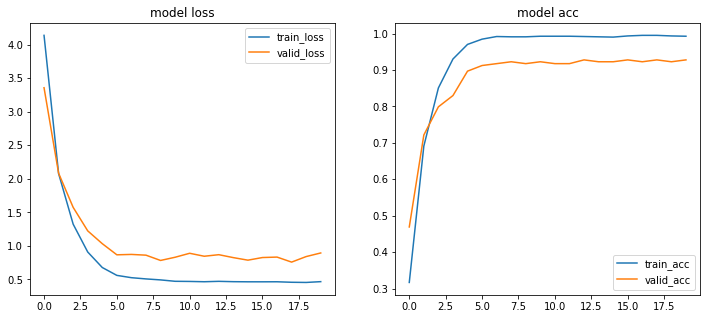

In [20]:
plt.figure(figsize=(12, 5))
for i, (k, v) in enumerate(train_history.items()):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    plt.plot(np.arange(len(v)), v, label=k)
    plt.legend(loc='best')
    plt.title('model '+ k.split('_')[-1])
plt.show()

## 顯示預測結果

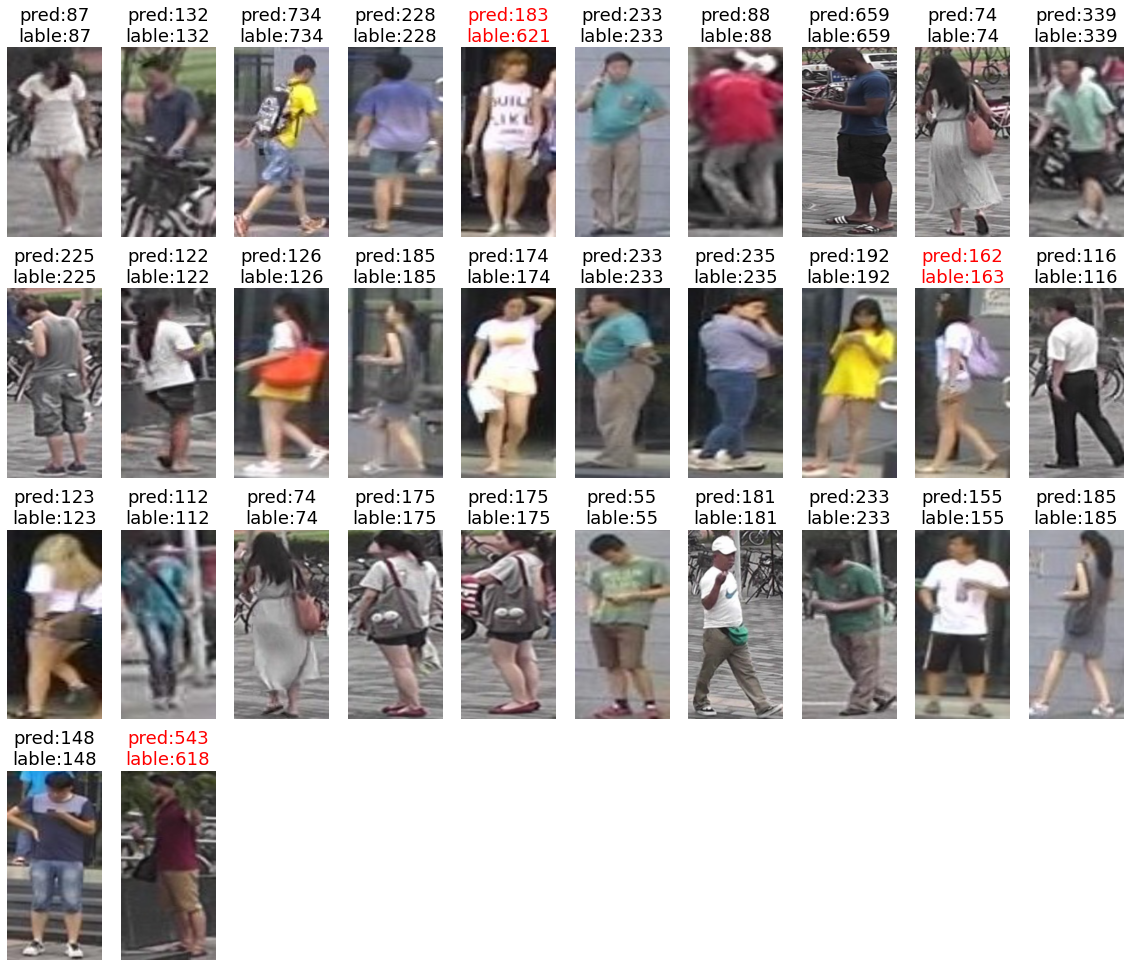

In [21]:
def visualize_model(model):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloaders['valid']))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        imshow(inputs.cpu(), labels.cpu(), preds.cpu())
        model.train(mode = was_training)
visualize_model(model_ft)